In [2]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

In [3]:
from celcomen.models.celcomen import celcomen
from celcomen.models.simcomen import simcomen

In [4]:
from celcomen.training_plan.train import train
from celcomen.datareaders.datareader import get_dataset_loaders

In [18]:
from celcomen.utils.helpers import calc_gex, get_pos, get_pos, calc_sphex, normalize_g2g

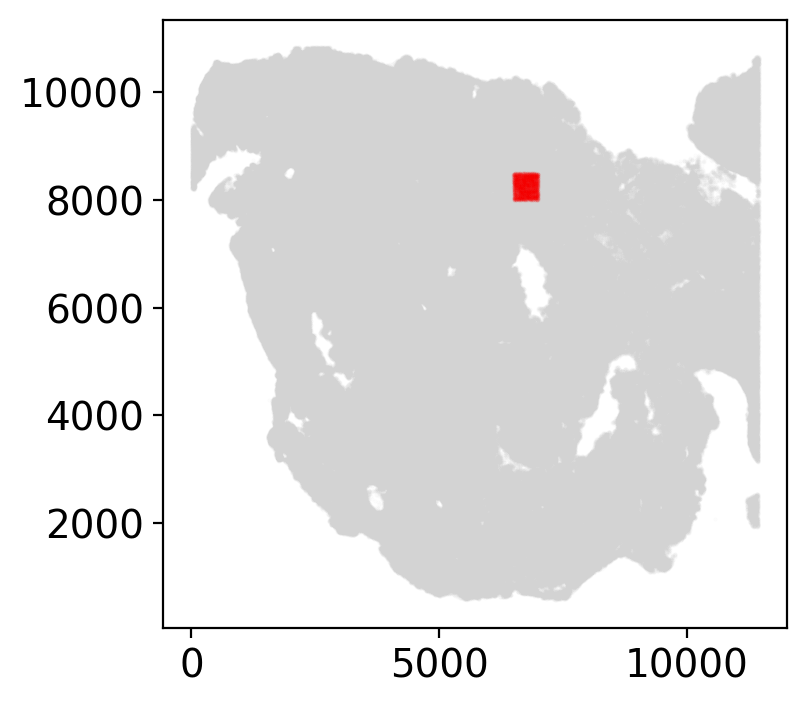

In [7]:
# read in xenium
avis = sc.read_10x_h5('data/xenium_human_gbm/cell_feature_matrix.h5')
avis.var_names = avis.var_names.astype(str)
avis.var_names_make_unique()
# remove cells with no counts
sc.pp.filter_cells(avis, min_counts=100)
# normalize the data
sc.pp.normalize_total(avis, target_sum=1e6)
sc.pp.log1p(avis)
# read in the spatial
df = pd.read_csv('data/xenium_human_gbm/cells.csv.gz', index_col=0)
df = df.loc[avis.obs.index]
# view the tissue and choose a specific area to focus on
fig, ax = plt.subplots()
ax.grid(False)
ax.scatter(df['x_centroid'], df['y_centroid'], s=0.1, alpha=0.1, color='lightgray')
mask = (df['x_centroid'] < 7000) & (df['x_centroid'] > 6500)
mask = mask & (df['y_centroid'] < 8500) & (df['y_centroid'] > 8000)
ax.scatter(df.loc[mask, 'x_centroid'], df.loc[mask, 'y_centroid'], s=0.1, alpha=0.1, color='r')

In [8]:
avis

AnnData object with n_obs × n_vars = 628324 × 480
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'

/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


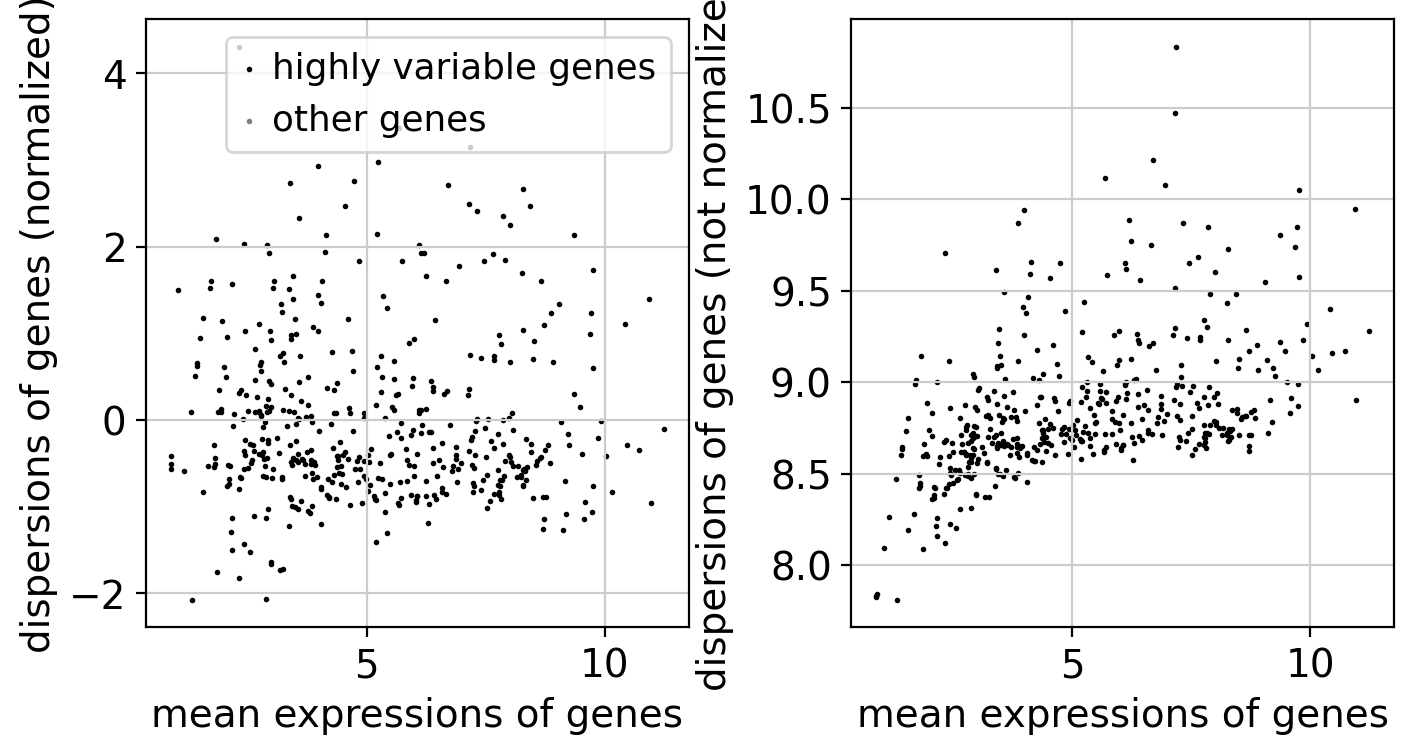

there are 480 hvgs


In [9]:
# add spatial and subset
avis.obsm['spatial'] = df.loc[avis.obs.index, ['x_centroid','y_centroid']].values
avis = avis[mask].copy()
# compute PCA for the spatial dataset using HVGs
avis.uns['log1p']['base'] = np.e
sc.pp.highly_variable_genes(avis, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5, n_top_genes=avis.shape[1])
sc.pl.highly_variable_genes(avis)
# report how many HVGs we're going to use
print('there are', avis.var['highly_variable'].sum(), 'hvgs')

In [10]:
from scipy.spatial.distance import pdist, squareform
# create a gene subset for testing
genes = avis.var_names[avis.var['highly_variable']].tolist()
avis = avis[:, genes ].copy()

# retrieve positions from the data # only needed for simcomen later
pos = torch.from_numpy(df[['x_centroid','y_centroid']].values)
# convert the gene expression data to numpy
x = torch.from_numpy(avis[:, genes].X.todense())
# sphere normalize the data (just in case)
norm_factor = torch.pow(x, 2).sum(1).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# compute the distances
distances = squareform(pdist(df.loc[mask, ['x_centroid','y_centroid']]))
# compute the edges as two cell widths apart so 30µm
edge_index = torch.from_numpy(np.array(np.where((distances < 15)&(distances != 0))))

avis.obs["sangerID"] = "sample1"

avis.write_h5ad(
    'data/xenium_human_gbm/avis_for_debug_loading.h5',
)


# define the parameters of the model
n_genes = len(genes)
learning_rate = 5e-2
zmft_scalar = 1e-1
seed = 0
epochs = 200
n_neighbors = 6
# instantiate the model, input and output will be the same
model_rev = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)

In [12]:
avis

AnnData object with n_obs × n_vars = 1781 × 480
    obs: 'n_counts', 'sangerID'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

In [13]:
h5ad_path='data/xenium_human_gbm/avis_for_debug_loading.h5'

loader = get_dataset_loaders(h5ad_path, "sangerID", 6, 'cuda', True, )

Step 1
=====
Number of graphs in the current batch: 1
DataBatch(x=[1781, 480], edge_index=[2, 7724], y=[1], pos=[1781, 2], batch=[1781], ptr=[2])



In [19]:
n_neighbors=6
n_genes = len(genes)
learning_rate = 5e-2
zmft_scalar = 1e-1
seed = 0
epochs = 200


model = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
model.to("cuda")
input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)

model.set_g2g(torch.from_numpy(input_g2g))
model.set_g2g_intra(torch.from_numpy(input_g2g))
model.to("cuda")

losses = train(epochs, learning_rate, model, loader, zmft_scalar=zmft_scalar, seed=1, device="cuda")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.00it/s]


[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

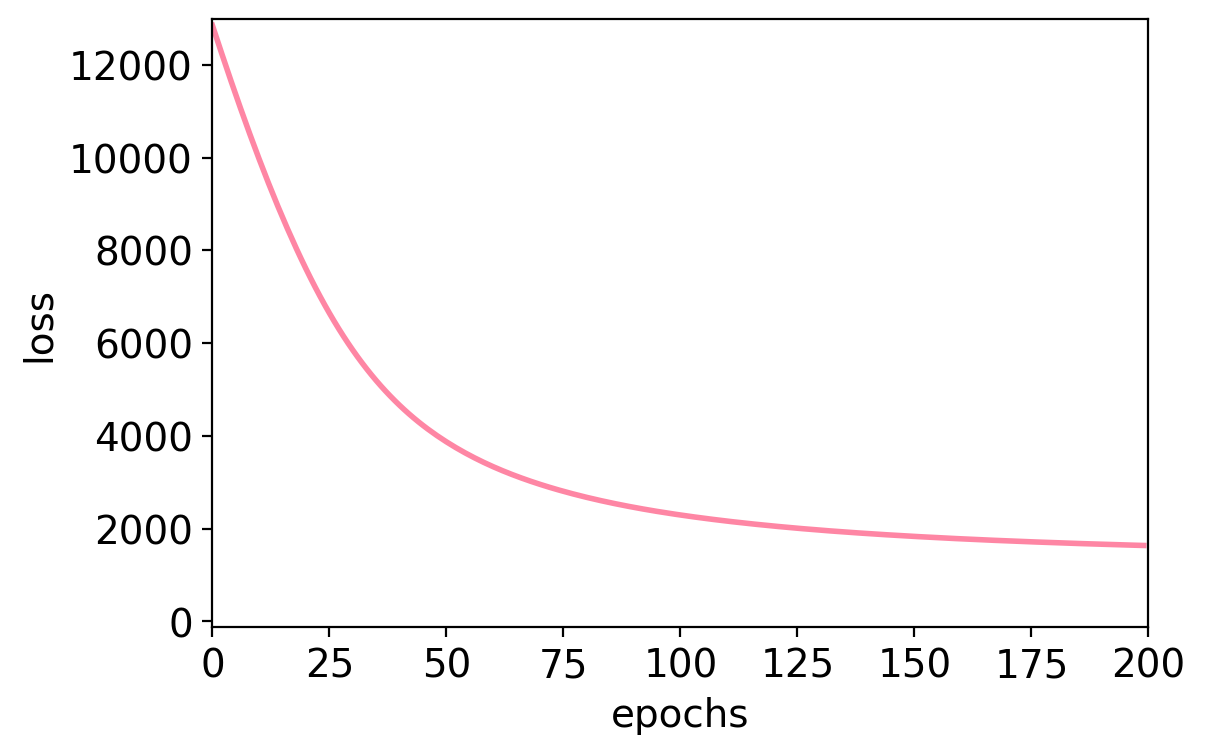

In [20]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

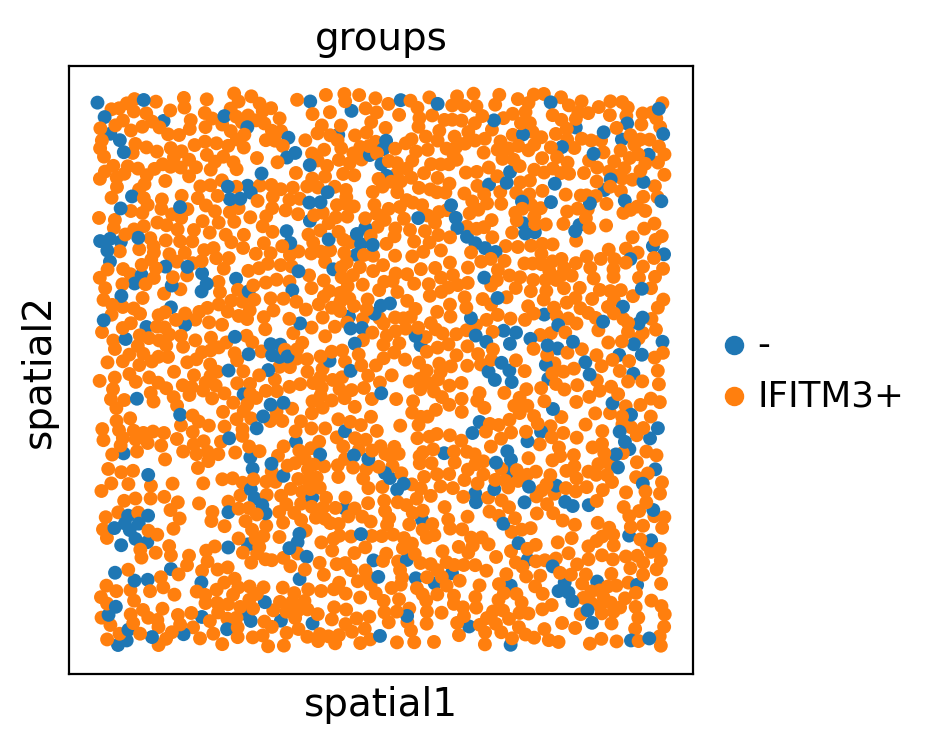

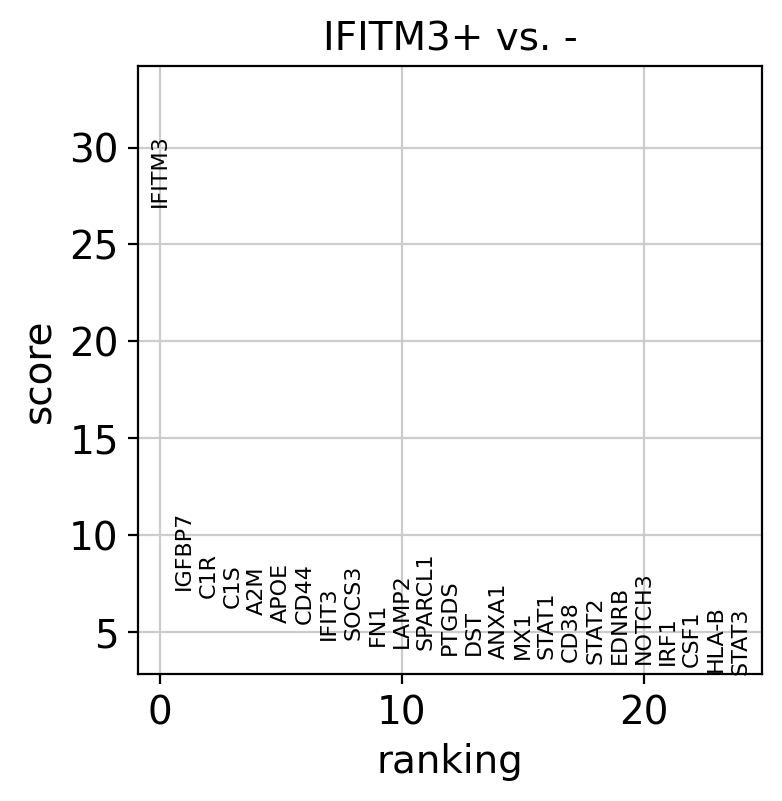

In [21]:
# define the genes that distinguish ISG15 spots currently
avis_sub = avis.copy()
avis_sub.obs['groups'] = (sc.get.obs_df(avis_sub, keys=['IFITM3']).max(1) > 0).map({True:'IFITM3+', False:'-'})
sc.pl.embedding(avis_sub, basis='spatial', color=['groups'], use_raw=False, s=1e2)
# calculate differential expression
sc.tl.rank_genes_groups(avis_sub, method='wilcoxon', use_raw=False, groupby='groups', group=['IFITM3+'], reference='-')
sc.pl.rank_genes_groups(avis_sub, n_genes=25, sharey=False)

/tmp/ipykernel_1657485/1489802821.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
/tmp/ipykernel_1657485/148

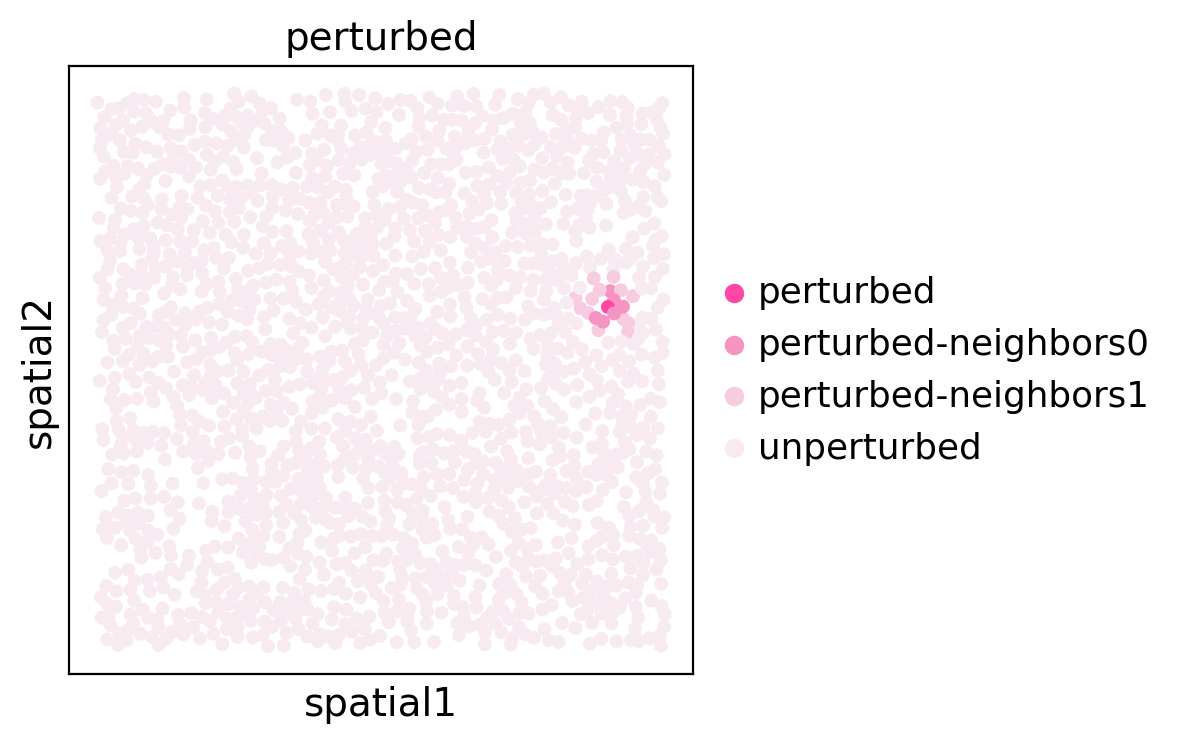

In [22]:
# propose an X introducing ISG15 inflammation
proposed_x = avis_sub.X.toarray().copy()
# adjust the X so we artificially introduce signaling to the center left side of the tissue
np.random.seed(0)
df_gex = sc.get.obs_df(avis_sub, keys=['IFITM3'])['IFITM3']
mask = avis_sub.obs.index == np.random.choice(avis_sub.obs.index[df_gex > 0], size=1)[0]
idx = np.where(avis_sub.var_names == 'IFITM3')[0][0]
proposed_x[mask, idx] = 0
avis_sub.obs['perturbed'] = 'unperturbed'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 15)[1]] = 'perturbed-neighbors0'
avis_sub.obs.loc[mask, 'perturbed'] = 'perturbed'
avis_sub.uns['perturbed_colors'] = ['#ff47a6','#f593c2','#f7cbe0','#f7ebf1']
sc.pl.embedding(avis_sub, basis='spatial', color=['perturbed'], use_raw=False, s=1e2)

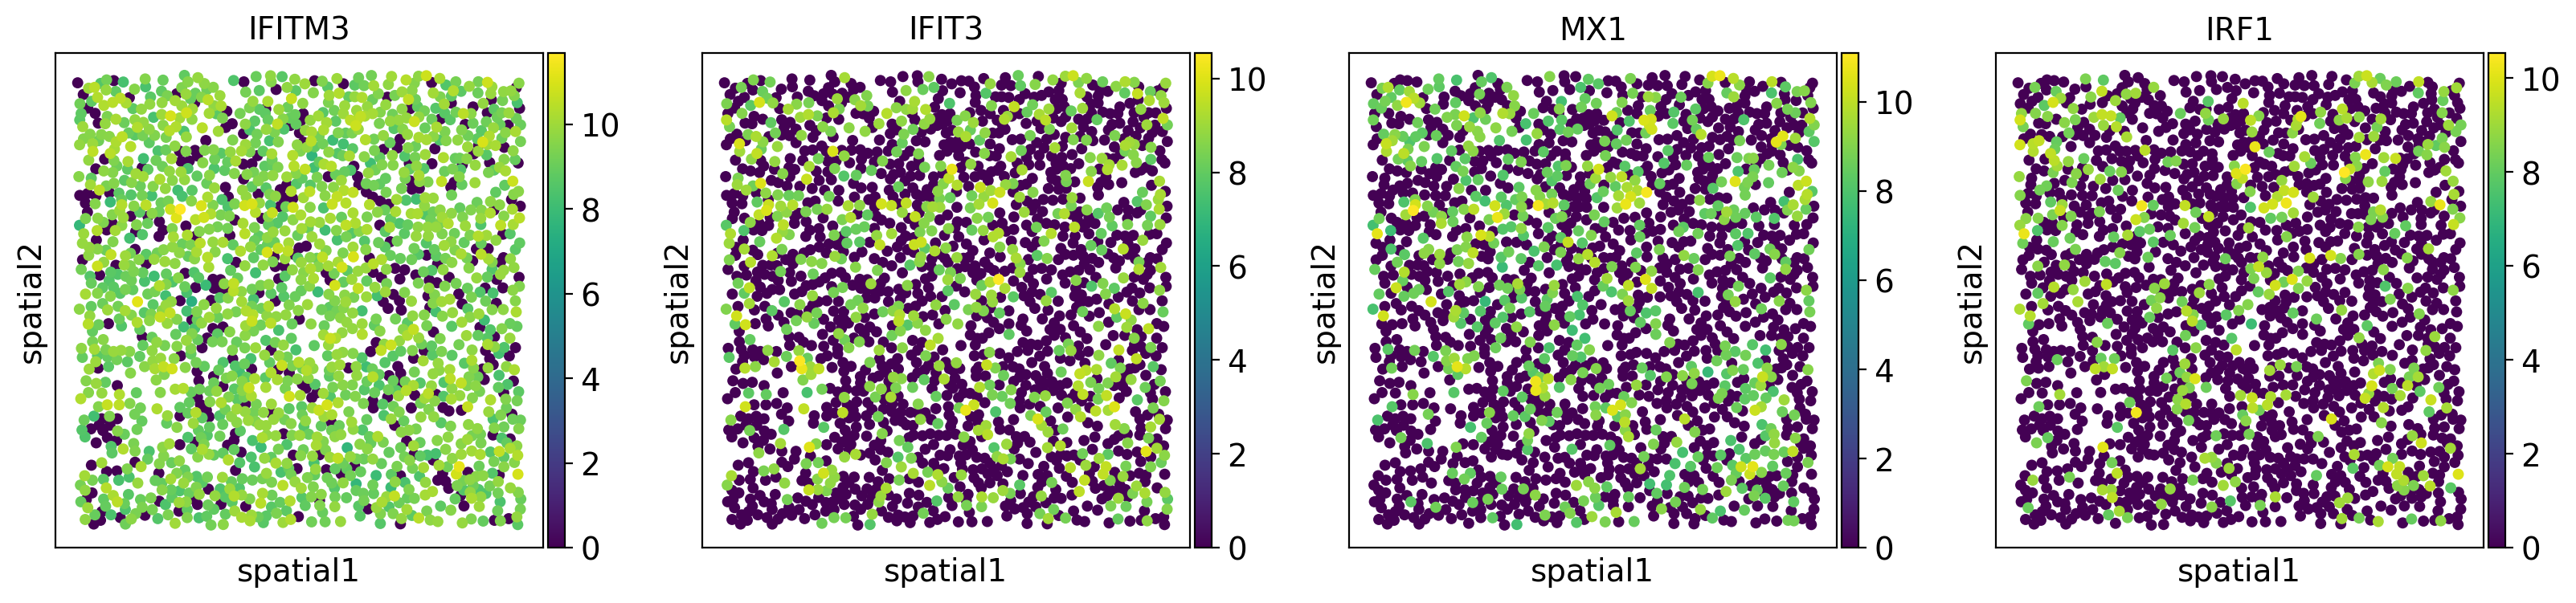

In [23]:
# demonstrate what the proposed x looks like pre scaling
avis_sub.X = proposed_x
sc.pl.embedding(avis_sub, basis='spatial', color=['IFITM3','IFIT3','MX1','IRF1'], use_raw=False, s=1e2)

In [24]:
# define the parameters of the model
n_genes = avis_sub.shape[1]
learning_rate = 1e-3
zmft_scalar = 1e-1
seed = 0
epochs = 50
# instantiate the model, input and output will be the same
simmodel = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
# now perform the simulation
np.random.seed(seed)
# convert the gene expression data to numpy
x = torch.from_numpy(proposed_x)
# sphere normalize the data (just in case)
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# artifically set the g2g matrix
simmodel.set_g2g(model.conv1.lin.weight.clone().detach())
simmodel.set_g2g_intra(model.lin.weight.clone().detach())
# initialize a gene expression matrix
assert np.isnan(x.detach().numpy()).sum() == 0
input_sphex = calc_sphex(x.to('cuda')).clone()

# move tensors and model to device cuda
device="cuda"
simmodel.set_sphex(input_sphex)
simmodel.to("cuda")

simcomen(
  (conv1): GCNConv(480, 480)
  (lin): Linear(in_features=480, out_features=480, bias=True)
)

In [25]:
# set up the optimizer
optimizer = torch.optim.SGD(simmodel.parameters(), lr=learning_rate, momentum=0)
# keep track of the losses per data object
loss, losses = None, []
# train the model
simmodel.train()
tmp_gexs = []
# work through epochs
edge_index = edge_index.to('cuda')
for epoch in tqdm(range(epochs), total=epochs):
    # derive the message as well as the mean field approximation
    msg, msg_intra, log_z_mft = simmodel(edge_index, 1)
    if (epoch % 5) == 0:
        tmp_gex = simmodel.gex.clone().detach().cpu().numpy()
        tmp_gexs.append(tmp_gex)
    # compute the loss and track it
    loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(simmodel.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
    losses.append(loss.detach().cpu().numpy()[0][0])
    # derive the gradients, update, and clear
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                                                                                                                       | 0/50 [00:00<?, ?it/s]

self.gex device is cuda:0
edge_index device is cuda:0


  2%|███▌                                                                                                                                                                           | 1/50 [00:29<24:06, 29.53s/it]

self.gex device is cuda:0
edge_index device is cuda:0


  4%|███████                                                                                                                                                                        | 2/50 [00:59<23:55, 29.90s/it]

self.gex device is cuda:0
edge_index device is cuda:0


  6%|██████████▌                                                                                                                                                                    | 3/50 [01:30<23:54, 30.52s/it]

self.gex device is cuda:0
edge_index device is cuda:0


  8%|██████████████                                                                                                                                                                 | 4/50 [02:01<23:33, 30.72s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [02:32<22:54, 30.54s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 12%|█████████████████████                                                                                                                                                          | 6/50 [03:03<22:31, 30.72s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [03:34<22:08, 30.89s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [04:05<21:33, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [04:36<21:08, 30.93s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [05:06<20:32, 30.81s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [05:37<20:03, 30.86s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [06:08<19:34, 30.89s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [06:39<19:04, 30.93s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [07:10<18:33, 30.93s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [07:41<17:57, 30.80s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [08:12<17:33, 30.99s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [08:43<17:02, 30.98s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [09:14<16:30, 30.95s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [09:44<15:54, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [10:15<15:23, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [10:46<14:55, 30.86s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [11:17<14:22, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [11:47<13:49, 30.73s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [12:18<13:17, 30.68s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [12:49<12:50, 30.81s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [13:20<12:20, 30.84s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [13:50<11:45, 30.68s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [14:21<11:17, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [14:52<10:46, 30.77s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [15:23<10:16, 30.84s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [15:53<09:43, 30.69s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [16:24<09:12, 30.71s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [16:55<08:43, 30.78s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [17:26<08:12, 30.77s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [17:56<07:39, 30.64s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [18:27<07:10, 30.74s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [18:58<06:39, 30.76s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [19:29<06:09, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [19:59<05:36, 30.59s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [20:30<05:07, 30.75s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [21:01<04:37, 30.78s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [21:32<04:06, 30.78s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [22:02<03:35, 30.74s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [22:33<03:04, 30.68s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [23:04<02:34, 30.80s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [23:35<02:03, 30.76s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [24:05<01:32, 30.69s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [24:36<01:01, 30.68s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [25:07<00:30, 30.69s/it]

self.gex device is cuda:0
edge_index device is cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [25:38<00:00, 30.76s/it]


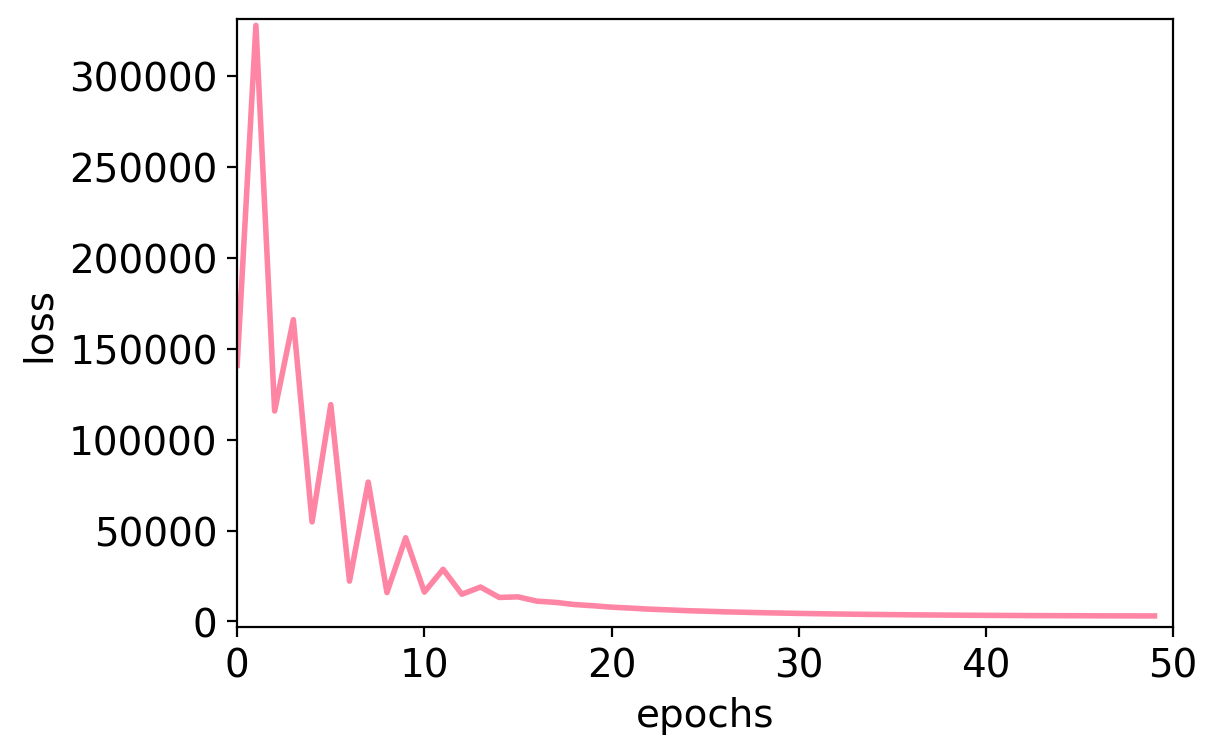

In [26]:
# plot the loss
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
# retrieve the data
output_gex = simmodel.gex.detach().cpu().numpy()
output_msg = msg.detach().cpu().numpy()

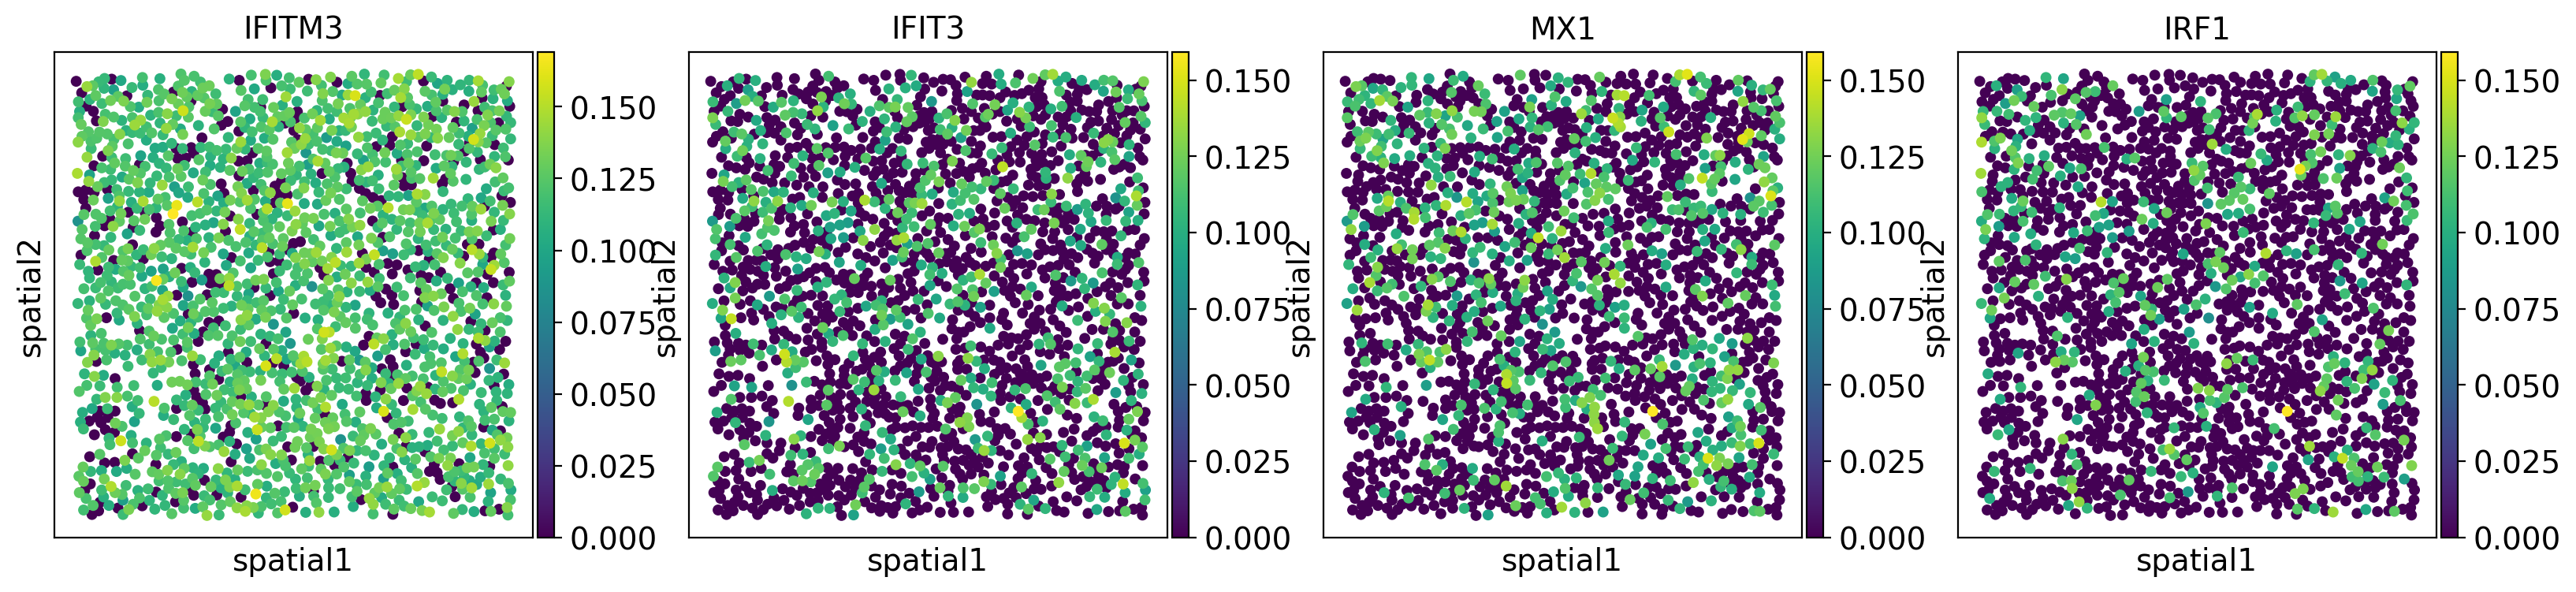

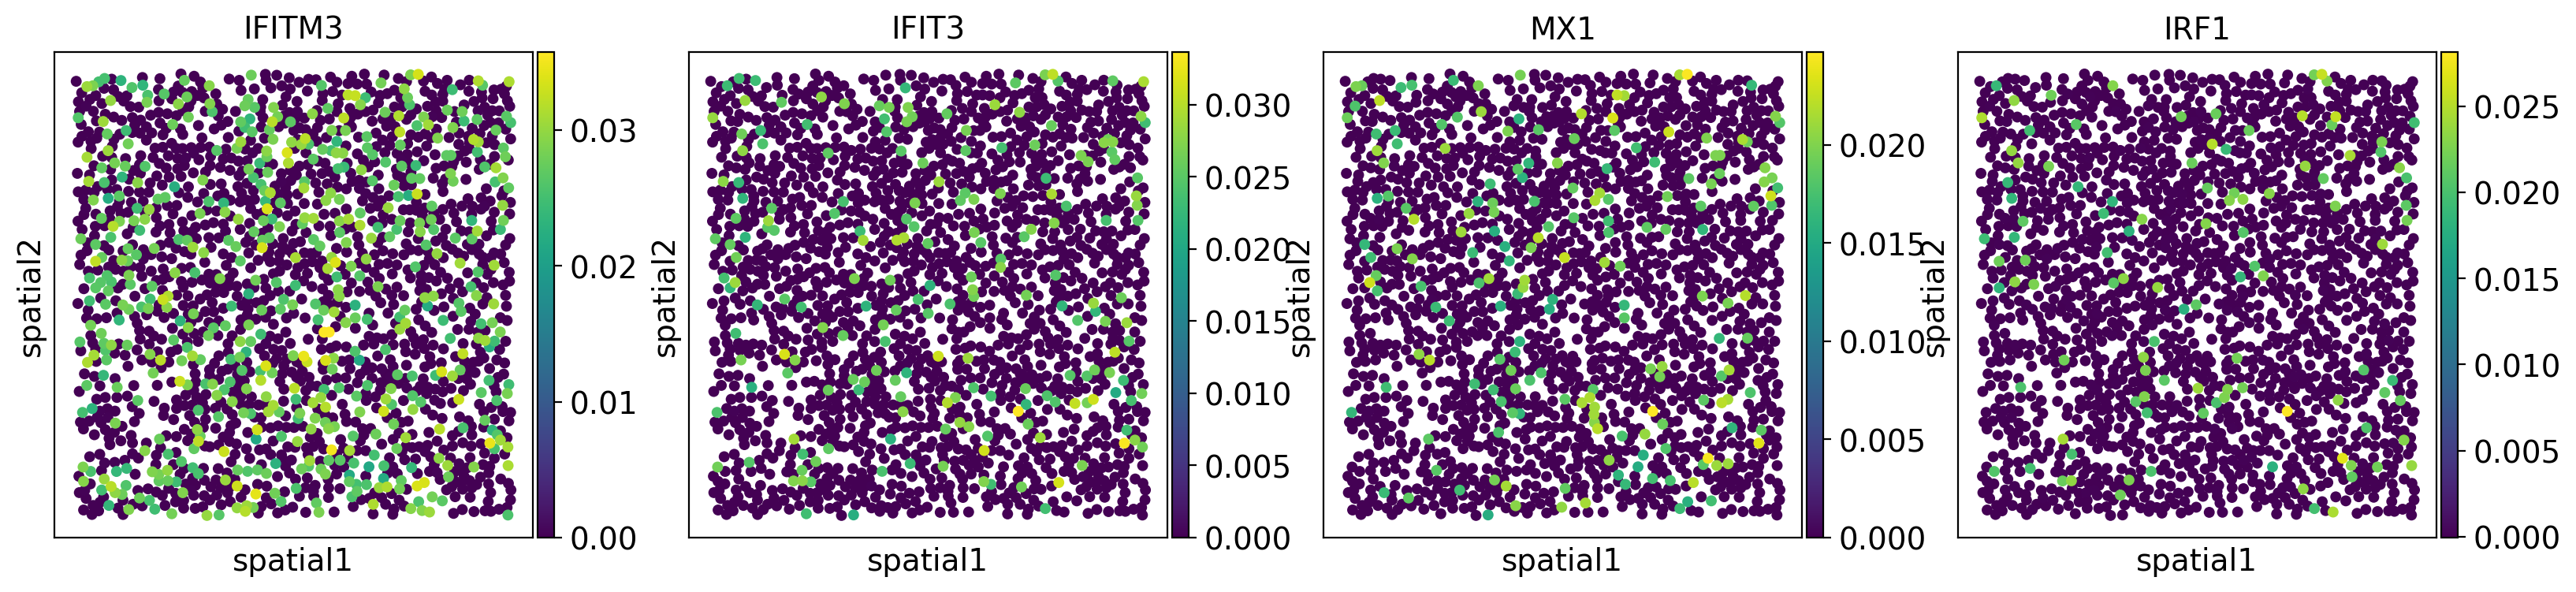

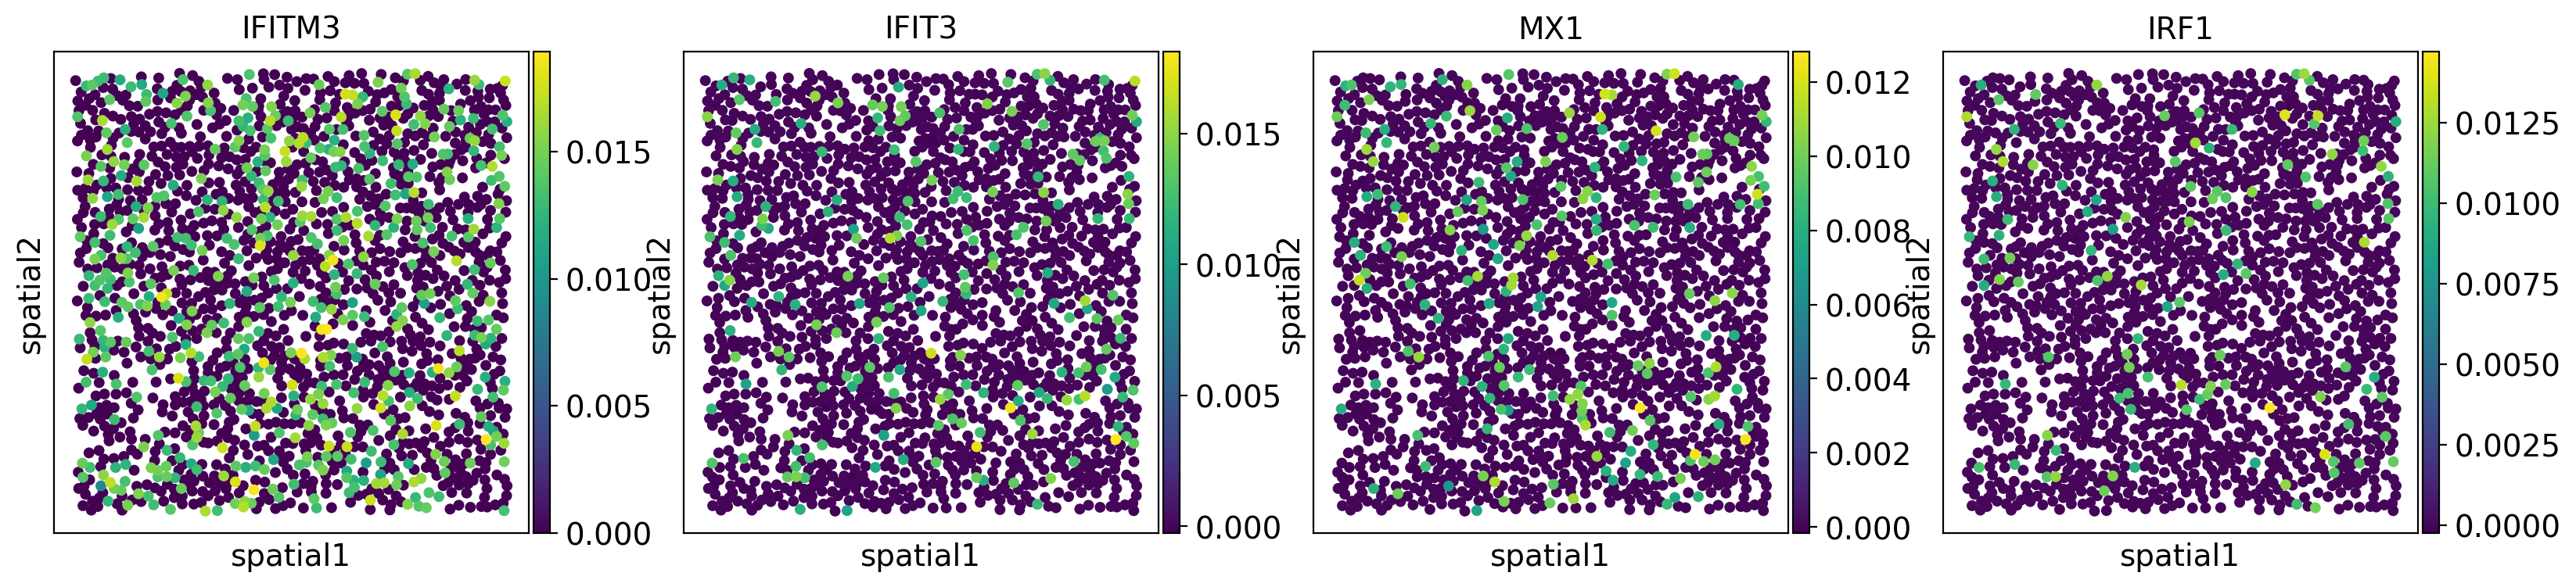

In [27]:
# find the genes of interest
genes = ['IFITM3','IFIT3','MX1','IRF1']
genes = [x for x in genes if x in avis_sub.var_names.tolist()]
# add the layers
for idx, tmp_gex in enumerate(tmp_gexs):
    avis_sub.layers[f'input{idx}'] = tmp_gex
avis_sub.layers['output'] = output_gex
# plot the genes of interest
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input0')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input3')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='output')

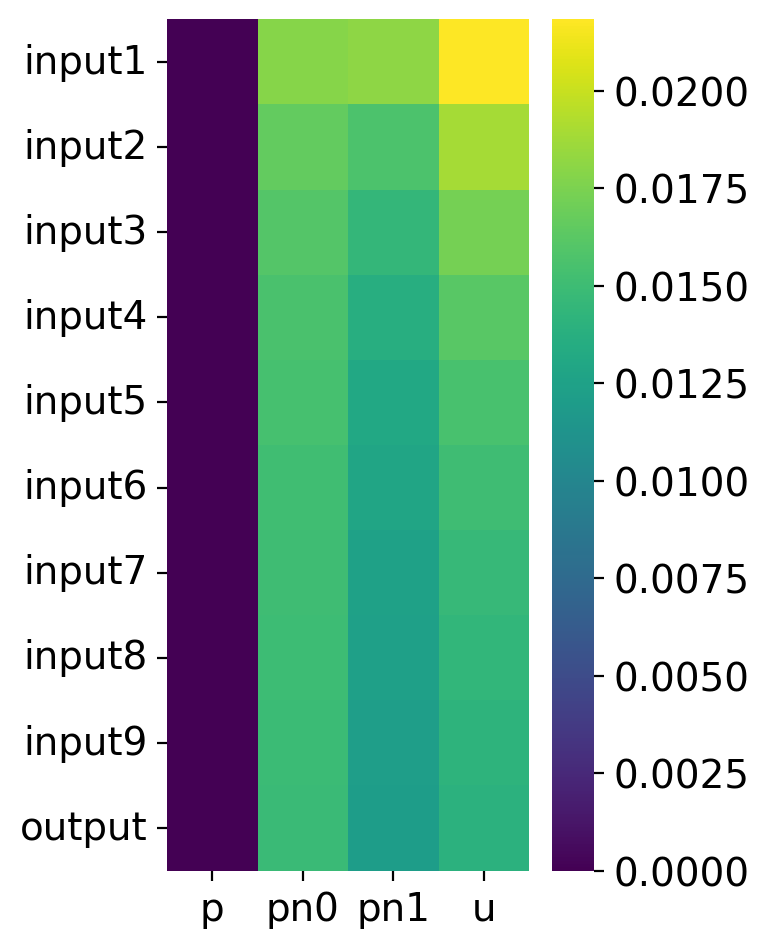

In [28]:
# compute the differential within the area of interest vs outside
avis_sub.layers['diff'] = avis_sub.layers['output'] - avis_sub.layers['input0']
mask0 = avis_sub.obs['perturbed'] == 'unperturbed'
mask1 = avis_sub.obs['perturbed'] == 'perturbed'
diff_in_vs_out_p = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# now compute differential for neighbors
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
diff_in_vs_out_pn0 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
diff_in_vs_out_pn1 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# remove the perturbed genes to get a clean look
perturbed_genes = ['IFITM3']
perturbed_label = 'ifitm3'
diff_in_vs_out_p = diff_in_vs_out_p.loc[~diff_in_vs_out_p.index.isin(perturbed_genes)]
diff_in_vs_out_pn0 = diff_in_vs_out_pn0.loc[~diff_in_vs_out_pn0.index.isin(perturbed_genes)]
diff_in_vs_out_pn1 = diff_in_vs_out_pn1.loc[~diff_in_vs_out_pn1.index.isin(perturbed_genes)]
# write these matrices out
diff_in_vs_out_p.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_p.csv')
diff_in_vs_out_pn0.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn0.csv')
diff_in_vs_out_pn1.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn1.csv')
# do not include isg15 itself
genes_ = pd.DataFrame(avis_sub.uns['rank_genes_groups']['names']).iloc[:25, 0].tolist()[1:]
# retrieve the results
df_expr = pd.DataFrame(columns=['p','pn0','pn1','u'])
for layer in ['input1','input2','input3','input4','input5','input6','input7','input8','input9','output']:
    # compute the expression
    mask1 = avis_sub.obs['perturbed'] == 'perturbed'
    expr_p = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
    expr_pn0 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
    expr_pn1 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'unperturbed'
    expr_u = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    df_expr.loc[layer] = expr_p, expr_pn0, expr_pn1, expr_u
# derive the scores
fig, ax = plt.subplots(figsize=[2.9, 5.6])
ax = sns.heatmap(df_expr, cmap='viridis')
ax.grid(False)